In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_3D import stack_generator, data_generator
# from model_3D_interconnect import make_generator
from model_3D import make_generator
from loss_3D import generator_loss

1 Physical GPUs, 1 Logical GPUs


In [2]:
frame_start =  0
frame_end =  8
patch_size =  160
n_patches =  1
n_channel =  0
augment = False 
shuffle = True 
batch_size = 1
lp = 1.0
add_noise = True

GT_image_dr = r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\Average'
lowSNR_image_dr =r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\Average'


gt,low=stack_generator(GT_image_dr,lowSNR_image_dr, fr_start=frame_start,fr_end=frame_end)

x_train, y_train, x_valid, y_valid = data_generator(gt, low, patch_size, n_patches, n_channel, 
                                                    threshold=0, ratio=1.0,lp=lp,
                                                    fr_start=frame_start, fr_end=frame_end
                                                    ,augment=augment, shuffle=shuffle,add_noise=add_noise)

(976, 8, 1, 320, 320)
(976, 320, 320, 8, 1)
976
The training set shape is: (976, 160, 160, 8, 1)
The validation set shape is: (0, 160, 160, 8, 1)


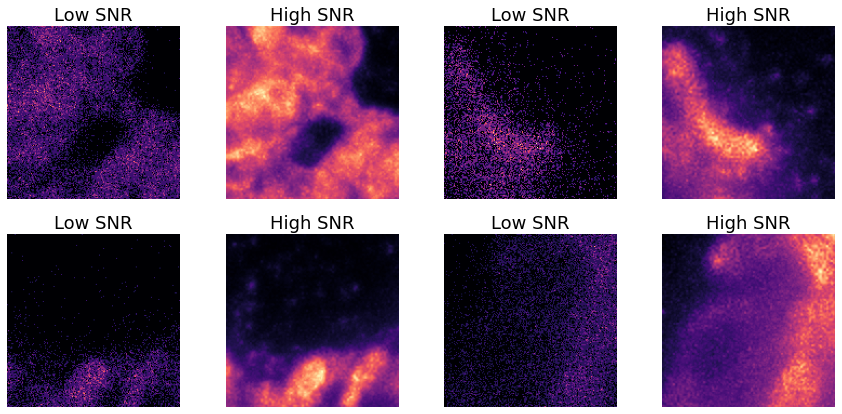

In [3]:
mip_x_train=np.max(x_train,axis=3)
mip_y_train=np.max(y_train,axis=3)

ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(mip_y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [4]:
model_save_directory = r"D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\unet_rcan_microtubule.h5" 
load_model_save_directory = r"D:\Models\Data generator\ddx39b-son\ddx39B-file_4.h5" 


n_epochs =  200
gen_lr = 1e-4

filters =[32,64,128]
num_filters = filters[0]
filters_cab=num_filters/16
num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,frame_end-frame_start,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
# generator.load_weights(load_model_save_directory)



def scheduler(epoch, lr):
    if np.mod(epoch+1,20)==0:
        return lr*0.8
    else:
        return lr

callbacks = [
    EarlyStopping(patience=100, verbose=1),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

In [5]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/200
 15/878 [..............................] - ETA: 8:16 - loss: 3.1890 - conv3d_33_loss: 0.3502 - conv3d_135_loss: 2.8389

KeyboardInterrupt: 